In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from collections import Counter

In [4]:
usr = os.path.expanduser( '~' )
print(usr)
protoFile = usr +"/openpose/models/pose/body_25/pose_deploy.prototxt"
weightsFile =usr + "/openpose/models/pose/body_25/pose_iter_584000.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

/home/takeshi


In [39]:

#--------------------------------------
def getKeypoints(output,inWidth, inHeight,numKeys=9,thresholdKey=110):
    # se obtiene primero los keypoints 
    keypoints=[]
    for i in range (numKeys):
        probMap = output[0, i, :, :]
        probMap = cv2.resize(probMap, (inWidth, inHeight))
        mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)
        _,mapMask = cv2.threshold(mapSmooth*256,thresholdKey,255,cv2.THRESH_BINARY)
        contours,_ = cv2.findContours(np.uint8(mapMask), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            blobMask = np.zeros(mapMask.shape)
            blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
            maskedProbMap = mapSmooth * blobMask
            _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
            keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],) +(i,))
    return keypoints


#--------------------------------------
def getDistances(keysPart,gP):
    matchesInMask=[]
    for key in keysPart :

        tmp=[]
        for j in range(len(gP)):

            if gP[j] and [key[0],key[1]] in gP[j]:
                tmp=[]
                tmp.append([[key[0],key[1]],key[-1],j,-1,-1])
                break

            elif gP[j] and not [key[0],key[1]] in gP[j]:
                restas=np.subtract(gP[j],[key[0],key[1]])
                distMIN = np.linalg.norm(restas,axis=1)
                tmp.append([[key[0],key[1]],key[-1],j,np.argmin(distMIN),np.min(distMIN)])
        matchesInMask.append(tmp)
    return matchesInMask

#--------------------------------------
def ordenaKeypoints(keypoints,numKeys):
    # ORDENO DE IZQUIERDA A DERECHA (LA PRIMER COORDENADA)
    l=0
    for i in range(numKeys):
        tmp = [item[0] for item in [item for item in keypoints if item[-1] == i]]
        order = np.argsort(tmp) if i==0 else np.concatenate((order,np.argsort(tmp)+l),axis=None)
        l+=len(tmp)
    
    return [keypoints[i] for i in order]


#--------------------------------------
def asignaEspacios(lista,maxPeople):
    espacios = list(range(maxPeople))

    defaul=[]
    for keyT in lista:
        if len(keyT)==1:
            defaul.append(keyT[0][2])
    #descarto espacios ya ocupados
    for d in defaul:
        espacios.remove(d)
    #lista con valores ya asignados
    subLista=[x[0] for x in lista if len(x)==1]

    while espacios:
        #lista con valores por asignar, guardo indice para despues modificar con asignacion
        sublista2=[x for x in lista if len(x)>1]
        indexes=[i for i,x in enumerate(lista) if len(x)>1]
        tmp=[]
        if len(sublista2) == 1:
            lista[indexes[0]] = [[sublista2[0][0][0],sublista2[0][0][1],espacios[0],-1,-1]]
            break
        for x in sublista2:
            for key in x:
                if key[2] == espacios[0]:
                    tmp.append(key)
        # esta lista es la nueva de acuerdo a la asignacion de la distancia mas corta
        keyTmp=[tmp[np.argmin([x[-1] for x in tmp])][0],
                tmp[np.argmin([x[-1] for x in tmp])][1],
               tmp[np.argmin([x[-1] for x in tmp])][2],
                -1,
                -1]
        subLista.append(keyTmp)
        lista[indexes[np.argmin([x[-1] for x in tmp])]] = [keyTmp]
        espacios.pop(0)

    #quito [] sobrantes
    lista = [x[0] for x in lista]
    return lista


#----------------------
# FUNCION PRINCIPAL
def getconectionJoints(output,inHeight,inWidth,thresKeyP=110,numKeys=9 ):
    # relacion entre indice de heatmaps y joints -> [hm,jointA,jointB]
    conections = [[57,0,1],[40,1,2],[43,2,3],[45,3,4],[48,1,5],[51,5,6],[53,6,7]] #primero puede ser NO necesario
    
    # se obtiene primero los keypoints 
    keypoints = getKeypoints(output,inWidth, inHeight,numKeys,thresholdKey=thresKeyP)

    # cuento max personas encontradas
    conteo=Counter([i[-1] for i in keypoints])
    maxPeople = max(list(conteo.values()))
    avgPeople = round(sum(list(conteo.values()))/len(list(conteo.values())))
    if maxPeople > avgPeople :
        maxPeople = avgPeople
    sk = np.zeros([maxPeople,8,2])


    # por cada conexion se compara los keypoints # AQUI EMPEZARIA EL LOOP POR CADA CONEXION
    for con in conections:
        #con = conections[0]    # OPCION PARA 1 CASO, DESCOMENTAR Y COMENTAR LINEA ANTERIOR (QUITAR IDENTACION)
        gP=[]
        for i in range(maxPeople):
            gP.append([])
        #
        print("CONECTION",con)      
        probMap = output[0, con[0], :, :]
        probMap = cv2.resize(probMap, (inWidth, inHeight))
        #cv2.imwrite(os.path.expanduser( '~' )+"/Documents/heatmap_"+str(con[0])+".jpg",probMap)
        mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)
        thresh =-256 if mapSmooth.max() < 0.1 else 256
        minthresh = mapSmooth.max()*thresh/2 if thresh == 256 else mapSmooth.min()*thresh/2
        if minthresh >15:
            _,mapMask = cv2.threshold(mapSmooth*thresh,minthresh-10,255,cv2.THRESH_BINARY)
        else:
            _,mapMask = cv2.threshold(mapSmooth*thresh,minthresh-1,255,cv2.THRESH_BINARY)
        contours,_ = cv2.findContours(np.uint8(mapMask), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # OBTENGO CENTROIDES PARA PODER SEPARAR LAS MASCARAS EN SUBCONJUNTOS DE COORDENADAS
        cents=[]
        gruposDist=False
        for cont in contours:
            cents.append(np.mean(cont, axis=0)[0])
        #ordeno de izquierda a derecha (en eje x)
        cents = [cents[i] for i in np.argsort([item[0] for item in cents])]


        gruposDist=len(cents)< maxPeople
        #obtengo coordenadas de todos los puntos que no tengan valor en cero
        maskV = np.transpose(np.nonzero(mapMask == 255))

        # SEPARO POR CONJUNTOS DE ACUERDO A LOS CENTROIDES MAS CERCANOS
        for v in maskV:
            distMin=np.linalg.norm(np.subtract(cents,[v[1],v[0]]),axis=1)
            # agrego a la lista en el grupo de la menor distancia
            gP[np.argmin(distMin)].append([v[1],v[0]]) # primero [1,0] para 'acomodar'

        keyspartA = [k for k in keypoints if k[-1]==con[1] ]
        keyspartB = [k for k in keypoints if k[-1]==con[2] ]
        
        
        if keyspartA[0][-1] == 1 and gruposDist and sk[0,0,0]==0:
            # CASO NO IDEAL QUE NO PUEDE CREAR 'BIEN' DESDE UN INICIO
            return []

        # CASO INICIAL, SI NO HUBO MISMO NUMERO DE PERSONAS y CABEZAS/CUELLOS DETECTADAS CON REGIONES
        if keyspartA[0][-1] == 0 and gruposDist and len(keyspartA) == maxPeople:
            # CASO EN QUE SE PUEDE AGREGAR CABEZAS AUNQUE HAYA MENOS REGIONES, SOLO SI HAY MISMO
            # NUMERO DE CABEZAS QUE PERSONAS
            for i in range(len(keyspartA)):
                sk[i,0,0] = keyspartA[i][0]
                sk[i,0,1] = keyspartA[i][1] 
        if keyspartA[0][-1] == 0 and gruposDist and len(keyspartA) != maxPeople:
            print("CASO PENDIENTE de TRATAR o quitar")

        # ELSE HACER LO DE ABAJO CON A y despues con B
        else:

            # AQUI OBTENGO DISTANCIAS MINIMAS O PERTENENCIAS DE LOS PUNTOS (JOINTS) A UN GRUPO 
            # matchesInMask_ = [ (key_x,key_y), num_joint, grupo_encontrado, index_distMin, distMin ]
            matchesInMaskA=getDistances(keyspartA,gP)
            matchesInMaskB=getDistances(keyspartB,gP)

            modifA = False
            # CASOS INICIALES E IDEALES
            if max([len(i) for i in matchesInMaskA]) == 1 and (matchesInMaskA[0][0][1]==0 or matchesInMaskA[0][0][1]==1):
                for item in matchesInMaskA:
                    sk[item[0][2],item[0][1],0] = item[0][0][0]
                    sk[item[0][2],item[0][1],1] = item[0][0][1]
            elif max([len(i) for i in matchesInMaskA]) != 1 and (matchesInMaskA[0][0][1]==0 or matchesInMaskA[0][0][1]==1):
                # CASO NO IDEAL DEL PRIMER GRUPO, AL MENOS UN KEYPOINT FUERA DE UNA REGION
                listaCorrespA = asignaEspacios(matchesInMaskA,maxPeople)
                modifA = True
            # CASO IDEAL PARA EL SEGUNDO GRUPO DE KEYPOINTS (B), TODOS DENTRO DE UNA REGION DE CORRESPONDENCIA
            if max([len(i) for i in matchesInMaskB]) == 1:
                for item in matchesInMaskB:
                    sk[item[0][2],item[0][1],0] = item[0][0][0]
                    sk[item[0][2],item[0][1],1] = item[0][0][1]
            
            #  CASO EN QUE HUBO KEYPOINTS FUERA DE REGIONES DE CORRESPONDENCIA
            else:
                # SE ASIGNA REGIONES DE ACUERDO A LAS DISTANCIAS MINIMAS DE CADA KEYPOINT A LA(s) REGION(es)
                listaCorrespB = asignaEspacios(matchesInMaskB,maxPeople)
                # CASO EN QUE NO HUBO MENOR NUMERO DE REGIONES 
                if not gruposDist:
                    for item in listaCorrespB:
                        sk[item[2],item[1],0] = item[0][0]
                        sk[item[2],item[1],1] = item[0][1]
                        
                # CASO EN QUE SI HUBO MENOR NUMERO DE REGIONES 
                # SE COMPARA CON DATOS ANTERIORES QUE ESTARAN 'CORRECTAS'
                else:
                    # EN CASO QUE HUBO MODIFICACION AL PRIMER GRUPO (A)
                    if modifA:
                        for itemB in listaCorrespB:
                            # BUSCO CORRESPONDENCIA PARA CADA PUNTO B CON EL A
                            tmp = [x for x in listaCorrespA if x[2]==itemB[2]][0]
                            # COMO A DEL PASO ANTERIOR ES CORRECTO, BUSCO EN QUE GRUPO(REGION) SE ASIGNO 
                            indexCorrecto = [i for i,item in enumerate(sk) if tmp[0] in item]
                            # REASIGNO B AL GRUPO DE A DEL PASO ANTERIOR
                            sk[indexCorrecto[0],itemB[1],0] = itemB[0][0]
                            sk[indexCorrecto[0],itemB[1],1] = itemB[0][1]
                    
                    # EN CASO QUE NO HUBO MODIFICACIONES AL PRIMER GRUPO (A)
                    else:
                        for itemB in listaCorrespB:
                            # BUSCO CORRESPONDENCIA PARA CADA PUNTO B CON EL A
                            tmp = [x for x in matchesInMaskA if x[0][2]==itemB[2]]
                            # COMO A DEL PASO ANTERIOR ES CORRECTO, BUSCO EN QUE GRUPO SE ASIGNO 
                            indexCorrecto = [i for i,item in enumerate(sk) if tmp[0] in item]
                            # REASIGNO B AL GRUPO DE A DEL PASO ANTERIOR
                            sk[indexCorrecto[0],itemB[1],0] = itemB[0][0]
                            sk[indexCorrecto[0],itemB[1],1] = itemB[0][1]
        print("\n\tSK AL MOMENTO:\n",sk)
    return sk

#----------------------
def drawSkeletons(frame,sk,plot=False):
    colors=[(41,23,255),(99,1,249),(251,10,255),(10,75,255),(41,243,186),(10,10,255),
                    (25,136,253),(40,203,253),(0,218,143),(0,218,116),(78,218,0),(253,183,31),
                    (148,241,4),(239,255,1),(253,145,31),(253,80,31),(248,8,207),(248,8,76)]
    conections = [[57,0,1],[40,1,2],[43,2,3],[45,3,4],[48,1,5],[51,5,6],[53,6,7]] #primero puede ser NO necesario
    
    rgbbkg = np.copy(frame)
    for i,s in enumerate(sk):
        rgbbkg = cv2.circle(rgbbkg,(int(s[0][0]),int(s[0][1])),6,(255,255,0),-1)
        rgbbkg = cv2.circle(rgbbkg,(int(s[1][0]),int(s[1][1])),6,(255,255,0),-1)
        rgbbkg = cv2.line(rgbbkg,
                              (int(s[conections[0][1],0]),int(s[conections[0][1],1])),
                              (int(s[conections[0][2],0]),int(s[conections[0][2],1])),
                              colors[0],
                              2)
        rgbkg = cv2.putText(rgbbkg,
                                    str(i)+", ("+str(s[0][0])+","+str(s[0][1])+")",
                                    (int(s[0][0]),int(s[0][1])),
                                    cv2.FONT_HERSHEY_SIMPLEX,
                                    0.5,
                                    (255, 255, 0) ,
                                    1,
                                    cv2.LINE_AA
                                   )
    for i in range(1,len(conections)):
        for s in sk:
            if int(s[conections[i][2],0]) != 0:
                rgbbkg = cv2.circle(rgbbkg,(int(s[conections[i][2],0]),int(s[conections[i][2],1])),6,(255,255,0),-1)
                rgbkg = cv2.putText(rgbbkg,
                                    str(i)+", ("+str(s[conections[i][2],0])+","+str(s[conections[i][2],1])+")",
                                    (int(s[conections[i][2],0])+15,int(s[conections[i][2],1])-15),
                                    cv2.FONT_HERSHEY_SIMPLEX,
                                    0.5,
                                    (255, 255, 0) ,
                                    1,
                                    cv2.LINE_AA
                                   )
            if int(s[conections[i][1],0]) != 0 and int(s[conections[i][2],0]) != 0:
                rgbbkg = cv2.line(rgbbkg,
                              (int(s[conections[i][1],0]),int(s[conections[i][1],1])),
                              (int(s[conections[i][2],0]),int(s[conections[i][2],1])),
                              colors[i],
                              2)
                
    
    if plot:
        plt.imshow(rgbbkg)
    return rgbbkg


In [6]:
!ls ../../human_detector/scripts/

human_detector_server.py     __pycache__  utils_pointing.py
pointing_detector_server.py  tsts.jpg	  utils.py


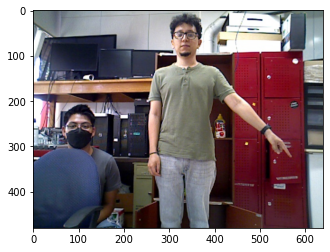

In [7]:
frame = cv2.imread("../../human_detector/scripts/tsts.jpg")


# Specify the input image dimensions
inHeight = frame.shape[0]
inWidth = frame.shape[1]


# Prepare the frame to be fed to the network
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

# Set the prepared object as the input blob of the network
net.setInput(inpBlob)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [8]:
output = net.forward()

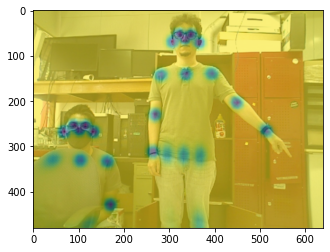

In [11]:
i = 25
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (inWidth, inHeight))



plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.imshow(probMap, alpha=0.6)

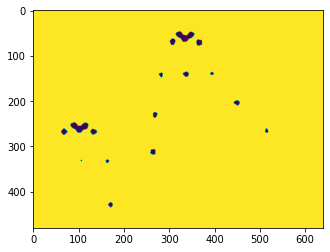

In [12]:
mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)
thresh =-256 if mapSmooth.max() < 0.1 else 256
minthresh = mapSmooth.max()*thresh/2 if thresh == 256 else mapSmooth.min()*thresh/2
if minthresh >15:
    _,mapMask = cv2.threshold(mapSmooth*thresh,minthresh-10,255,cv2.THRESH_BINARY)
else:
    _,mapMask = cv2.threshold(mapSmooth*thresh,minthresh-1,255,cv2.THRESH_BINARY)
contours,_ = cv2.findContours(np.uint8(mapMask), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(mapMask) ##MASK WITH KEY POINTS 0

CONECTION [57, 0, 1]

	SK AL MOMENTO:
 [[[100. 261.]
  [107. 331.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]]

 [[332.  60.]
  [339. 140.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]]]
CONECTION [40, 1, 2]

	SK AL MOMENTO:
 [[[100. 261.]
  [107. 331.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]]

 [[332.  60.]
  [339. 140.]
  [283. 140.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]]]
CONECTION [43, 2, 3]

	SK AL MOMENTO:
 [[[100. 261.]
  [107. 331.]
  [  0.   0.]
  [268. 228.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]]

 [[332.  60.]
  [339. 140.]
  [283. 140.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]]]
CONECTION [45, 3, 4]

	SK AL MOMENTO:
 [[[100. 261.]
  [107. 331.]
  [  0.   0.]
  [268. 228.]
  [267. 314.]
  [  0.   0.]
  [  0.   0.]
  [  0.   0.]]

 [[332.  60.]
  [339. 140.]
  [283. 140.]
  [ 

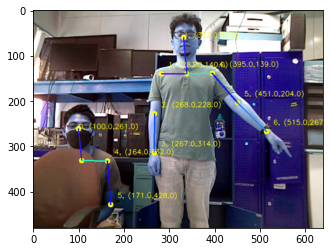

In [40]:
frameF = np.copy(frame)
poses = getconectionJoints(output,inHeight,inWidth)
print("=====\n",poses)
imageDraw = drawSkeletons(frameF,poses,plot=True)
